# Project2, Group 7

Here is a breakdown of each member's contributions to the project2, Authorship is listed **alphabetically by given name**:

**Biyu Zou**

* task 10,11,12

**Chun Zhou**

* task 3,4,5

**Tianci Wang**

* task 9

**Yaliang Cai**

* task 6,7,8

**Yuhe Bian**

* task 1,2

And all team members jointly contributed to:
* Redesign and implementation of the `solve` method

In [3]:
# task 1

Code Structure:

```
OptimizationProblem (Optimization Problem Abstraction)
    ↑ (Composition Relationship)
OptimizationMethod (Optimization Method Base Class)
    ↑ (Inheritance Relationship)
    ├── NewtonMethod (Newton's Method)
    ├── NewtonMethodExactLineSearch (Newton's Method with Exact Line Search)
    ├── NewtonMethodInexactLineSearch (Newton's Method with Inexact Line Search)
    └── QuasiNewtonMethod (Quasi-Newton Method Base Class)
        ↑ (Inheritance Relationship)
        ├── GoodBroyden (Good Broyden Method)
        ├── BadBroyden (Bad Broyden Method)
        ├── SymmetricBroyden (Symmetric Broyden Method)
        ├── DFP (Davidon-Fletcher-Powell Method)
        └── BFGS (Broyden-Fletcher-Goldfarb-Shanno Method)
```

In [4]:
import numpy as np

class OptimizationProblem:
    def __init__(self, f, grad=None):
        self.f = f
        self.grad = grad

    def evaluate(self, x):
        return float(self.f(x))

    def gradient(self, x):
        if self.grad is None:
            raise NotImplementedError("No gradient provided.")
        return np.array(self.grad(x), dtype=float)

In [5]:
# task 2: general opitimization class

In [6]:
class OptimizationMethod:
    def __init__(self, problem, tol=1e-6, max_iter=100):
        self.problem = problem
        self.tol = tol
        self.max_iter = max_iter
        self.history = []

    def compute_direction(self, x):
        # need implemention
        raise NotImplementedError

    def line_search(self, x, s, g):
        alpha = 1.0  # will be changed in the subsequet tasks 
        return alpha

    def solve(self, x0):
        x = np.array(x0, dtype=float)
        g = self.problem.gradient(x)
        n = x.size
        H = np.eye(n)
        self.history = [x.copy()]
        for _ in range(self.max_iter):
            if np.linalg.norm(g) < self.tol:
                break
            s = self.compute_direction(x, g, H)
            if s is None:
                s = -g
            alpha = self.line_search(x, s, g)
            s_step = alpha * s
            x_new = x + s_step
            g_new = self.problem.gradient(x_new)
            y = g_new - g
            H = self.update(H, s_step, y)
            x, g = x_new, g_new
            self.history.append(x.copy())
        return x


In [7]:
#task 3

def fd_hessian(f, x, eps=1e-6):
    n = x.size
    H = np.zeros((n, n))
    fx = f(x)
    for i in range(n):
        ei = np.zeros(n); ei[i] = 1.0
        for j in range(i, n):
            ej = np.zeros(n); ej[j] = 1.0
            if i == j:
                H[i, i] = (f(x + eps * ei) - 2 * fx + f(x - eps * ei)) / eps**2
            else:
                fpp = f(x + eps * ei + eps * ej)
                fpm = f(x + eps * ei - eps * ej)
                fmp = f(x - eps * ei + eps * ej)
                fmm = f(x - eps * ei - eps * ej)
                H[i, j] = H[j, i] = (fpp - fpm - fmp + fmm) / (4 * eps**2)
    return 0.5 * (H + H.T)

class NewtonMethod(OptimizationMethod):
    def compute_direction(self, x, g, H=None):
        Hx = fd_hessian(self.problem.evaluate, x)
        return -np.linalg.solve(Hx, g)
    def update(self, H, s, y):  
        return H

In [8]:
# task 4
from scipy.optimize import minimize_scalar

class NewtonMethodExactLineSearch(NewtonMethod):
    def line_search(self, x, s, g):
        phi = lambda alpha: self.problem.evaluate(x + alpha * s)
        res = minimize_scalar(phi, bounds=(0, 1), method='bounded')
        return res.x

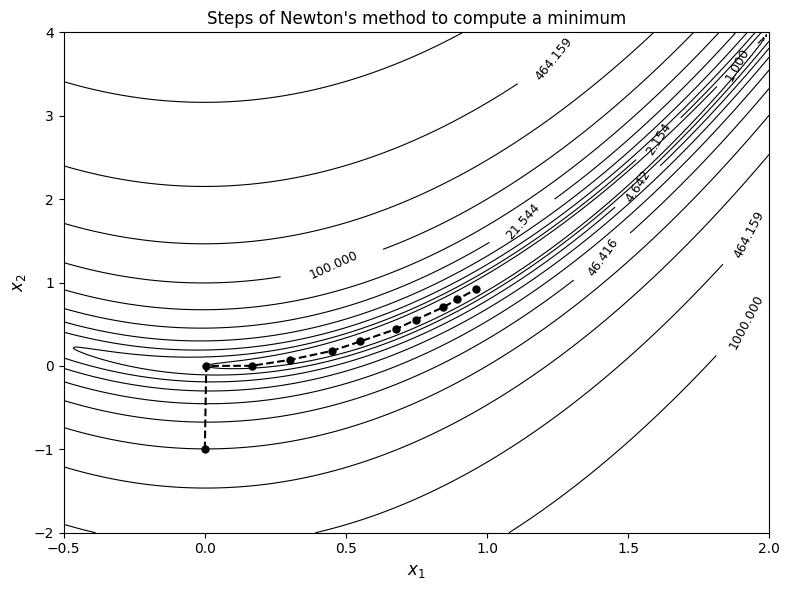

In [ ]:
#task 5
import matplotlib.pyplot as plt
import numpy as np

# Define Rosenbrock function and its gradient
def rosenbrock_f(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

def rosenbrock_grad(x):
    df_dx0 = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    df_dx1 = 200 * (x[1] - x[0]**2)
    return np.array([df_dx0, df_dx1])

problem = OptimizationProblem(f=rosenbrock_f, grad=rosenbrock_grad)
optimizer = NewtonMethodExactLineSearch(problem, max_iter=10)
x0 = np.array([0.0, -1.0])
xmin = optimizer.solve(x0)
trajectory = np.vstack(optimizer.history)

x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-2, 4, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = 100 * (Y - X**2)**2 + (1 - X)**2

plt.figure(figsize=(8, 6))

levels = np.logspace(0, 3, 10) 
CS = plt.contour(X, Y, Z, levels=levels, colors='black', linewidths=0.8)
plt.clabel(CS, inline=True, fontsize=9, fmt="%.3f")


plt.plot(trajectory[:, 0], trajectory[:, 1], 'k--', linewidth=1.5)
plt.plot(trajectory[:, 0], trajectory[:, 1], 'ko', markersize=5)

plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.title("Steps of Newton's method to compute a minimum", fontsize=12)
plt.xlim([-0.5, 2.0])
plt.ylim([-2.0, 4.0])
plt.grid(False)
plt.tight_layout()
plt.show()


In [10]:
# Task 6 
def line_search_goldstein_wolfe(problem, x, p, grad_x,
                                rho=0.01, sigma=0.1,
                                tau1=9.0, tau2=0.1, tau3=0.5,
                                alpha1=1.0, fbar=-np.inf, max_iter=50):

    phi0 = problem.evaluate(x)
    dphi0 = float(np.dot(grad_x, p))

    def phi(a): return problem.evaluate(x + a * p)
    def dphi(a): return float(np.dot(problem.gradient(x + a * p), p))

    # === Bracketing phase ===
    alpha_prev = 0.0
    alpha_i = alpha1
    mu = (fbar - phi0) / (rho * dphi0)

    for i in range(1, max_iter + 1):
        f_alpha_i = phi(alpha_i)

        if f_alpha_i <= fbar:
            return alpha_i

        if (f_alpha_i > phi0 + rho * alpha_i * dphi0) or (i > 1 and f_alpha_i >= phi(alpha_prev)):
            ai, bi = alpha_prev, alpha_i
            break

        fprime_alpha_i = dphi(alpha_i)

        if abs(fprime_alpha_i) <= -sigma * dphi0:
            return alpha_i

        if fprime_alpha_i >= 0:
            ai, bi = alpha_i, alpha_prev
            break

        if mu <= 2 * alpha_i - alpha_prev:
            alpha_next = mu
        else:
            alpha_next = 0.5 * ((2 * alpha_i - alpha_prev) + min(mu, alpha_i + tau1 * (alpha_i - alpha_prev)))

        alpha_prev, alpha_i = alpha_i, alpha_next
    else:
        return alpha_i

    if "ai" not in locals() or "bi" not in locals():
        return alpha_i
    
    # === Sectioning phase ===
    aj, bj = ai, bi
    for j in range(max_iter):
        # choose αj ∈ [aj+τ2(bj−aj), bj−τ3(bj−aj)]
        alpha_j = 0.5 * ((1 - tau2 - tau3) * aj + (tau2 + tau3) * bj)

        f_alpha_j = phi(alpha_j)

        if (f_alpha_j > phi0 + rho * alpha_j * dphi0) or (f_alpha_j >= phi(aj)):
            aj, bj = aj, alpha_j
        else:
            fprime_alpha_j = dphi(alpha_j)
            if abs(fprime_alpha_j) <= -sigma * dphi0:
                return alpha_j
            aj = alpha_j
            if (bj - aj) * fprime_alpha_j >= 0:
                bj = aj
            else:
                bj = bj
    return alpha_j


In [11]:
# Task 7
x0 = np.array([-1.2, 1.0])
g0 = problem.gradient(x0)
p0 = -g0  # search direction

rho, sigma = 0.01, 0.1
tau1, tau2, tau3 = 9.0, 0.1, 0.5

for alpha1 in (0.1, 1.0):  # Table 2.6.1
    alpha = line_search_goldstein_wolfe(
        problem, x0, p0, g0,
        rho=rho, sigma=sigma,
        tau1=tau1, tau2=tau2, tau3=tau3,
        alpha1=alpha1
    )
    x1 = x0 + alpha * p0
    f0 = problem.evaluate(x0)
    f1 = problem.evaluate(x1)

    # Check Wolfe–Powell conditions
    armijo_ok = (f1 <= f0 + rho * alpha * np.dot(g0, p0))
    wolfe_ok = (abs(np.dot(problem.gradient(x1), p0)) <= -sigma * np.dot(g0, p0))

    print(f"alpha1={alpha1} -> alpha={alpha}")
    print(f"f(x0)={f0}, f(x1)={f1}")
    print(f"Armijo: {armijo_ok}, Wolfe: {wolfe_ok}\n")


alpha1=0.1 -> alpha=0.0008099999999999998
f(x0)=24.199999999999996, f(x1)=4.141734836674481
Armijo: True, Wolfe: True

alpha1=1.0 -> alpha=0.0007289999999999999
f(x0)=24.199999999999996, f(x1)=4.227608042702007
Armijo: True, Wolfe: True



In [12]:
# Task 8 
class NewtonMethodInexactLineSearch(NewtonMethod):
    def line_search(self, x, s, g):
        return line_search_goldstein_wolfe(
            self.problem, x, s, g,
            rho=0.01, sigma=0.1,
            tau1=9.0, tau2=0.1, tau3=0.5,
            alpha1=1.0
        )


In [13]:
# Task 9

import numpy as np

class QuasiNewtonMethod(OptimizationMethod):
    def __init__(self, problem, tol=1e-6, max_iter=100,
                 rho=0.01, sigma=0.1,
                 tau1=9.0, tau2=0.1, tau3=0.5,
                 alpha1=1.0, fbar=-np.inf):
        super().__init__(problem, tol, max_iter)
        # line-search (Wolfe + τ) parameters
        self.rho = rho
        self.sigma = sigma
        self.tau1 = tau1
        self.tau2 = tau2
        self.tau3 = tau3
        self.alpha1 = alpha1
        self.fbar = fbar
    
    def compute_direction(self, x, g, H):
        s_dir = -H @ g
        if float(g @ s_dir) >= 0.0:
            s_dir = -g.copy()
        return s_dir

    def line_search(self, x, s, g):
        return line_search_goldstein_wolfe(
            self.problem, x, s, g,
            rho=self.rho, sigma=self.sigma,
            tau1=self.tau1, tau2=self.tau2, tau3=self.tau3,
            alpha1=self.alpha1, fbar=self.fbar
        )

    def update(self, H, s, y):
        raise NotImplementedError



![Good Broyden](GoodBroyden.png)

In [14]:
# Task 9.1 good Broyden
class GoodBroyden(QuasiNewtonMethod):
    def update(self, H, s, y):
        # Compute G = H^{-1} implicitly by Sherman-Morrison
        Hy = H.dot(y)
        u = s - Hy
        denom = u @ y
        if abs(denom) < 1e-12:
            return H
        # Sherman–Morrison
        H_new = H + np.outer(u, u) / denom
        return H_new


![Bad Broyden](BadBroyden.png)

In [15]:
# Task 9.2 Bad Broyden
class BadBroyden(QuasiNewtonMethod):
    def update(self, H, s, y):
        u = s - H.dot(y)
        denom = u @ y
        if abs(denom) < 1e-12:
            return H
        H_new = H + np.outer(u, u) / denom
        return H_new


![Symmetric Broyden](SymmetricBroyden.png)

In [16]:
# Task 9.3 Symmetric Broyden
class SymmetricBroyden(QuasiNewtonMethod):
    def update(self, H, s, y):
        u = s - H.dot(y)
        denom = u @ y
        if abs(denom) < 1e-12:
            return H
        upd = np.outer(u, u) / denom
        H_new = H + 0.5 * (upd + upd.T)   # symmetrize
        return H_new


![DFP](DFP.png)

In [17]:
# Task 9.4 DFP
class DFP(QuasiNewtonMethod):
    def update(self, H, s, y, g, g_new):
        sy = s @ y
        if abs(sy) < 1e-12:
            return H
        Hy = H.dot(y)
        H_new = H + np.outer(s, s) / sy - np.outer(Hy, Hy) / (y @ Hy)
        return H_new



![BGFS](BGFS.png)

In [18]:
# Task 9.5 BFGS
class BFGS(QuasiNewtonMethod):
    def update(self, H, s, y):
        rho = 1.0 / (y @ s)
        I = np.eye(len(s))
        V = I - rho * np.outer(s, y)
        H_new = V @ H @ V.T + rho * np.outer(s, s)
        return H_new


In [19]:
# Task 9 
# Example usage
problem = OptimizationProblem(f=rosenbrock_f, grad=rosenbrock_grad)
x0 = np.array([-1.2, 1.0])

optimizer = BFGS(problem, max_iter=50)
xmin = optimizer.solve(x0)

print("Found minimum:", xmin)


Found minimum: [0.99999475 0.99998842]


In [20]:
# Task 10 (minimal): run BFGS once on Chebyquad (n=8)
import numpy as np
from chebyquad_problem import chebyquad, gradchebyquad
# If these are in my package, import accordingly:
# from my_optim import OptimizationProblem, BFGS

# Dimension for the test
n = 8

# Initial point strictly inside (0, 1) for better numerical stability
x0 = (np.arange(1, n + 1) / (n + 1)).astype(float)

# Build the optimization problem with objective and analytical gradient
problem = OptimizationProblem(chebyquad, gradchebyquad)

# Set up BFGS; tol is treated as a gradient-based stopping threshold
solver = BFGS(problem, tol=1e-8, max_iter=200)

# Run the solver
x_star = solver.solve(x0)

# Report final objective, gradient infinity norm, and iteration count
f_star = chebyquad(x_star)
g_inf = float(np.max(np.abs(gradchebyquad(x_star))))
iters = len(getattr(solver, "history", [x0])) - 1

print("Task 10: Chebyshev (n=8) with BFGS")
print("-----------------------------------")
print("x* =", np.array2string(x_star, precision=8, floatmode="fixed"))
print(f"f* = {f_star:.3e}")
print(f"||grad||_inf = {g_inf:.3e}")
print(f"iterations = {iters}")


Task 10: Chebyshev (n=8) with BFGS
-----------------------------------
x* = [0.05151023 0.19903229 0.30987603 0.42609755 0.57390245 0.69012397
 0.80096771 0.94848977]
f* = 2.492e-19
||grad||_inf = 2.892e-09
iterations = 19


In [ ]:
# Task 11: Chebyshev Problem — Computing Optimal Points and Comparing with SciPy
import numpy as np
from chebyquad_problem import chebyquad, gradchebyquad
from scipy.optimize import fmin_bfgs

# Build the optimization problem
cheby_problem = OptimizationProblem(chebyquad, gradchebyquad)

# Dimensions required by the assignment
dimensions = [4, 8, 11]

print("Task 11: Chebyshev Problem - Optimal Points Computation")
print("=" * 70)
print("Minimizing chebyquad corresponds to finding points x_j such that the")
print("sample mean in (1) best approximates the corresponding integrals.")
print("=" * 70)

# Storage for summary rows
results = {}

for n in dimensions:  
    print(f"\nDimension n = {n}")
    print("-" * 50)

    # Initial point (uniform grid in [0, 1])
    x0 = np.linspace(0, 1, n)
    print(f"Initial point: {x0}")

    # Our BFGS implementation
    print("\nOur BFGS Implementation:")
    try:
        solver = BFGS(cheby_problem, tol=1e-8, max_iter=(500 if n == 11 else 200))
        x_our = solver.solve(x0)
        f_our = cheby_problem.evaluate(x_our)
        it_our = len(getattr(solver, "history", [x0])) - 1

        print(f"  Optimal points: {x_our}")
        print(f"  Function value: {f_our:.2e}")
        print(f"  Iterations: {it_our}")

        results.setdefault(n, {})
        results[n]["our"] = (f_our, it_our)

    except Exception as e:
        print(f"  Error: {e}")
        results.setdefault(n, {})
        results[n]["our"] = ("ERROR", None)

    # SciPy fmin_bfgs (simple call: get x*, compute f*)
    print("\nScipy fmin_bfgs:")
    try:
        x_sc = fmin_bfgs(chebyquad, x0, fprime=gradchebyquad, gtol=1e-8, disp=False)
        f_sc = chebyquad(x_sc)

        print(f"  Optimal points: {x_sc}")
        print(f"  Function value: {f_sc:.2e}")
        print(f"  Iterations: --")  # not collected in this simple call

        results[n]["scipy"] = (f_sc, None)

        # Order-invariant comparison (Chebyquad is permutation-invariant in x)
        x_our_sorted = np.sort(x_our)
        x_sc_sorted = np.sort(x_sc)
        diff_x = np.linalg.norm(x_our_sorted - x_sc_sorted)
        diff_f = abs(f_our - f_sc)

        print("\nComparison (order-invariant):")
        print(f"  Point difference (L2, sorted): {diff_x:.2e}")
        print(f"  Function value difference:      {diff_f:.2e}")
        if diff_x < 1e-6 and diff_f < 1e-6:
            print("  Status: Solutions match (within tolerance)")
        else:
            print("  Status: Solutions differ")

    except Exception as e:
        print(f"  Error: {e}")
        results[n]["scipy"] = ("ERROR", None)

# Summary table
print("\n" + "=" * 70)
print("SUMMARY: Our BFGS vs SciPy fmin_bfgs")
print("=" * 70)
print(f"{'n':>3s} {'Method':>12s} {'Function Value':>15s} {'Iterations':>10s}")
print("-" * 70)
for n in dimensions:
    # Our BFGS
    f_val, it_val = results.get(n, {}).get("our", ("ERROR", None))
    if f_val == "ERROR":
        print(f"{n:3d} {'Our BFGS':>12s} {'ERROR':>15s} {'--':>10s}")
    else:
        print(f"{n:3d} {'Our BFGS':>12s} {f_val:15.2e} {it_val:10d}")

    # SciPy BFGS
    f_val, it_val = results.get(n, {}).get("scipy", ("ERROR", None))
    if f_val == "ERROR":
        print(f"{n:3d} {'Scipy BFGS':>12s} {'ERROR':>15s} {'--':>10s}")
    else:
        print(f"{n:3d} {'Scipy BFGS':>12s} {f_val:15.2e} {'--':>10s}")

Task 11: Chebyshev Problem - Optimal Points Computation
Minimizing chebyquad corresponds to finding points x_j such that the
sample mean in (1) best approximates the corresponding integrals.

Dimension n = 4
--------------------------------------------------
Initial point: [0.         0.33333333 0.66666667 1.        ]

Our BFGS Implementation:
  Optimal points: [0.11270167 0.37090055 0.62909945 0.88729833]
  Function value: 4.44e-19
  Iterations: 15

Scipy fmin_bfgs:
  Optimal points: [0.11270167 0.37090056 0.62909944 0.88729833]
  Function value: 4.33e-20
  Iterations: --

Comparison (order-invariant):
  Point difference (L2, sorted): 8.21e-09
  Function value difference:      4.01e-19
  Status: Solutions match (within tolerance)

Dimension n = 8
--------------------------------------------------
Initial point: [0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]

Our BFGS Implementation:
  Optimal points: [0.71885963 0.05051078 0.21194388 0.47958

Task 12: BFGS Inverse-Hessian Approximation Quality
Iterations: 23, final f(x) = 5.902e-18

  k        ||H-G^{-1}||_F      rel_F      ||I - H G||_F     secant_res
-----------------------------------------------------------------------
  0        2.962e+00   6.266e+00         1.103e+03        (n/a)
  1        2.382e+00   1.452e+00         7.486e+01      5.632e-16
  2        2.528e+00   1.176e+00         6.146e+01      2.619e-16
  3        2.533e+00   2.308e+00         8.887e+01      1.157e-16
  4        2.056e+00   2.102e+00         6.681e+01      1.311e-16
  5        2.271e+00   1.870e+00         6.982e+01      3.346e-17
  6        2.252e+00   1.770e+00         7.005e+01      3.359e-18
  7        2.301e+00   1.699e+00         6.986e+01      2.424e-18
  8        4.606e+00   2.736e+00         6.934e+01      3.635e-18
  9        8.193e+00   1.372e+00         6.052e+01      1.055e-17
 10        1.411e+02   9.246e-01         1.253e+02      5.617e-17
 11        4.852e+00   5.759e-01         

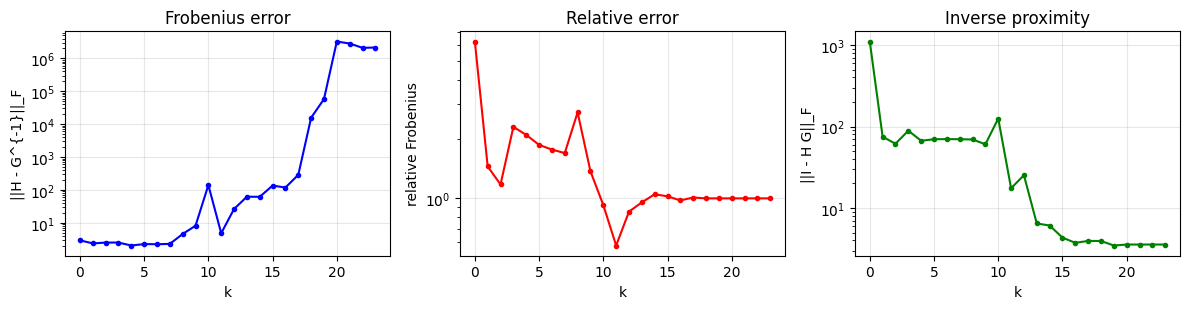

In [ ]:
# Task 12: Study H(k) ≈ G(x(k))^{-1} quality with growing k
# - Self-contained: does NOT call your BFGS.update (avoids signature mismatch)
# - Prefers your line_search_wolfe; otherwise falls back to Armijo backtracking
# - Builds G(x) by central differences on the gradient (more stable), symmetrized + light regularization

import numpy as np
import matplotlib.pyplot as plt
from chebyquad_problem import chebyquad, gradchebyquad

# ---------- Line search (use your global line_search_wolfe if present) ----------
def _fallback_backtracking(problem, x, p, g, alpha0=1.0, rho=1e-4, beta=0.5, max_iter=20):
    """Minimal Armijo backtracking used only if line_search_wolfe is not available."""
    fx = problem.evaluate(x)
    dg = float(np.dot(g, p))  # directional derivative
    # ensure descent direction
    if dg >= 0:
        p = -g
        dg = float(np.dot(g, p))
    alpha = alpha0
    for _ in range(max_iter):
        if problem.evaluate(x + alpha * p) <= fx + rho * alpha * dg:
            return alpha
        alpha *= beta
    return alpha

def _choose_line_search():
    """Return global line_search_wolfe if defined, else the fallback Armijo."""
    ls = globals().get('line_search_wolfe', None)
    if callable(ls):
        return ls
    return lambda problem, x, p, g: _fallback_backtracking(problem, x, p, g)

# ---------- Stable Hessian from gradient finite differences ----------
def true_hessian_via_grad_fd(problem, x, base_eps=None):
    """
    Build Hessian G(x) via central differences on the gradient (more stable than 2nd differences on f):
      G_ij ≈ (grad_i(x + h_j e_j) - grad_i(x - h_j e_j)) / (2 h_j)
    with component-wise steps h_j ~ sqrt(eps) * (1 + |x_j|).
    Then symmetrize and add a tiny Tikhonov regularization for numerical stability.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    G = np.zeros((n, n))
    macheps = np.finfo(float).eps
    if base_eps is None:
        base_eps = np.sqrt(macheps)
    h = base_eps * (1.0 + np.abs(x))
    I = np.eye(n)

    for j in range(n):
        xpj = x + h[j] * I[j]
        xmj = x - h[j] * I[j]
        gjp = problem.gradient(xpj)
        gjm = problem.gradient(xmj)
        G[:, j] = (gjp - gjm) / (2.0 * h[j])

    # Symmetrize
    G = 0.5 * (G + G.T)

    # Light regularization scaled by spectral norm
    try:
        s2 = np.linalg.norm(G, 2)
    except np.linalg.LinAlgError:
        s2 = np.linalg.norm(G, 'fro')
    tau = 1e-8 * max(1.0, s2)
    G += tau * np.eye(n)
    return G

# ---------- Standard BFGS inverse-Hessian update (in-cell) ----------
def bfgs_inverse_update(H, s, y):
    """
    Standard BFGS inverse-Hessian update:
      H_{k+1} = (I - ρ s y^T) H_k (I - ρ y s^T) + ρ s s^T,  with ρ = 1/(y^T s).
    Safeguard: if y^T s <= 0 or is tiny, return H unchanged.
    """
    ys = float(np.dot(y, s))
    if ys <= 1e-12:
        return H
    rho = 1.0 / ys
    I = np.eye(len(s))
    V = I - rho * np.outer(s, y)
    return V @ H @ V.T + rho * np.outer(s, s)

# ---------- Main study function ----------
def study_bfgs_inverse_hessian_quality(problem, x0, tol=1e-8, max_iter=30, verbose=True, plot=True):
    """
    Run BFGS (inverse form) and study the quality of H(k) ≈ G(x(k))^{-1} as k grows.
    We report:
      - frob:  ||H(k) - G(x(k))^{-1}||_F               (scale-sensitive)
      - rel:   frob / ||G(x(k))^{-1}||_F               (relative error)
      - invp:  ||I - H(k) G(x(k))||_F                  (dimensionless inverse-proximity, preferred)
      - secant residual: ||H(k) y(k-1) - s(k-1)||_2    (checks BFGS secant condition numerically)
    """
    line_search = _choose_line_search()

    x = np.array(x0, dtype=float)
    g = problem.gradient(x)
    n = len(x)

    # Initialize H(0) = I
    H = np.eye(n)

    # History
    xs = [x.copy()]
    gs = [g.copy()]
    H_hist = [H.copy()]
    frob_hist, rel_hist, invp_hist, secant_hist = [], [], [], []

    # Errors at k = 0
    G0 = true_hessian_via_grad_fd(problem, x)
    try:
        G0inv = np.linalg.inv(G0)
    except np.linalg.LinAlgError:
        G0inv = np.linalg.pinv(G0)
    E = H - G0inv
    frob0 = np.linalg.norm(E, 'fro')
    rel0 = frob0 / (np.linalg.norm(G0inv, 'fro') + 1e-18)
    invp0 = np.linalg.norm(np.eye(n) - H @ G0, 'fro')
    frob_hist.append(frob0); rel_hist.append(rel0); invp_hist.append(invp0)
    secant_hist.append(np.nan)  # no y,s yet

    # Iterate
    for k in range(1, max_iter + 1):
        if np.linalg.norm(g, np.inf) < tol:
            break

        # Step
        p = -H.dot(g)
        alpha = line_search(problem, x, p, g)
        x_new = x + alpha * p
        g_new = problem.gradient(x_new)

        # BFGS (inverse form)
        s = x_new - x
        y = g_new - g
        H = bfgs_inverse_update(H, s, y)

        # Metrics at x_new, H(k)
        Gk = true_hessian_via_grad_fd(problem, x_new)
        # ||I - H G||_F (preferred, no inversion)
        invp = np.linalg.norm(np.eye(n) - H @ Gk, 'fro')
        # ||H - G^{-1}||_F and relative error (use (pseudo-)inverse)
        try:
            Gkinv = np.linalg.inv(Gk)
        except np.linalg.LinAlgError:
            Gkinv = np.linalg.pinv(Gk)
        frob = np.linalg.norm(H - Gkinv, 'fro')
        rel = frob / (np.linalg.norm(Gkinv, 'fro') + 1e-18)
        # Secant residual
        sec = np.linalg.norm(H @ y - s)

        # Save
        xs.append(x_new.copy()); gs.append(g_new.copy()); H_hist.append(H.copy())
        frob_hist.append(frob); rel_hist.append(rel); invp_hist.append(invp); secant_hist.append(sec)

        # Move
        x, g = x_new, g_new

    if verbose:
        print("Task 12: BFGS Inverse-Hessian Approximation Quality")
        print("====================================================")
        print(f"Iterations: {len(xs)-1}, final f(x) = {problem.evaluate(xs[-1]):.3e}")
        print("\n  k        ||H-G^{-1}||_F      rel_F      ||I - H G||_F     secant_res")
        print("-----------------------------------------------------------------------")
        for k in range(len(xs)):
            sec = secant_hist[k]
            sec_str = f"{sec:12.3e}" if np.isfinite(sec) else "     (n/a)"
            print(f"{k:3d}     {frob_hist[k]:12.3e}   {rel_hist[k]:8.3e}      {invp_hist[k]:12.3e}   {sec_str}")

    if plot:
        ks = np.arange(len(xs))
        plt.figure(figsize=(12, 3.2))
        plt.subplot(1, 3, 1)
        plt.semilogy(ks, frob_hist, 'b-o', ms=3)
        plt.xlabel('k'); plt.ylabel('||H - G^{-1}||_F'); plt.title('Frobenius error'); plt.grid(True, alpha=0.3)

        plt.subplot(1, 3, 2)
        plt.semilogy(ks, rel_hist, 'r-o', ms=3)
        plt.xlabel('k'); plt.ylabel('relative Frobenius'); plt.title('Relative error'); plt.grid(True, alpha=0.3)

        plt.subplot(1, 3, 3)
        plt.semilogy(ks, invp_hist, 'g-o', ms=3)
        plt.xlabel('k'); plt.ylabel('||I - H G||_F'); plt.title('Inverse proximity'); plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return {
        "x_hist": xs,
        "g_hist": gs,
        "H_hist": H_hist,
        "err_frob": frob_hist,
        "err_rel": rel_hist,
        "err_inv_id": invp_hist,
        "secant_res": secant_hist,
    }

# ----------------------- Example run on Chebyquad -----------------------
# You can try n=4, 8, 11
n = 8
x0 = np.linspace(0.0, 1.0, n)
cheby_problem = OptimizationProblem(chebyquad, gradchebyquad)
_ = study_bfgs_inverse_hessian_quality(cheby_problem, x0, tol=1e-8, max_iter=30, verbose=True, plot=True)